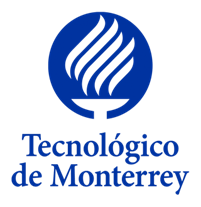

## Visión Computacional para imágenes y video (Gpo 10)
### Alumnos: 
* Armando Bringas Corpus - A01200230
* Guillermo Alfonso Muñiz Hermosillo - A01793101
* Jorge Luis Arroyo Chavelas - A01793023
* Samantha R Mancias Carrillo - A01196762
* Sofia E Mancias Carrillo - A01196563


### Profesores: 
* Dr. Gilberto Ochoa Ruiz
* Mtra. Yetnalezi Quintas Ruiz

# 7. Harris Edge & Corner Detection

## Table of Contents
1. [Libraries](#libraries)
2. [Color image to Grayscale conversion](#grayscale)
3. [Spatial derivative calculation](#spatial)
4. [Structure tensor setup](#tensor)
5. [Harris response calculation](#response)
6. [Find edges and corners using R](#find)
7. [Application and analysis](#applications)
8. [References](#references)

## Importing Libraries <a class="anchor" id="libraries" ></a>

In [126]:
import cv2
import matplotlib.pyplot as plt
from scipy import signal as sig
import numpy as np
from scipy.ndimage.filters import convolve

## 1. Color to Grayscale <a class="anchor" id="grayscale" ></a>

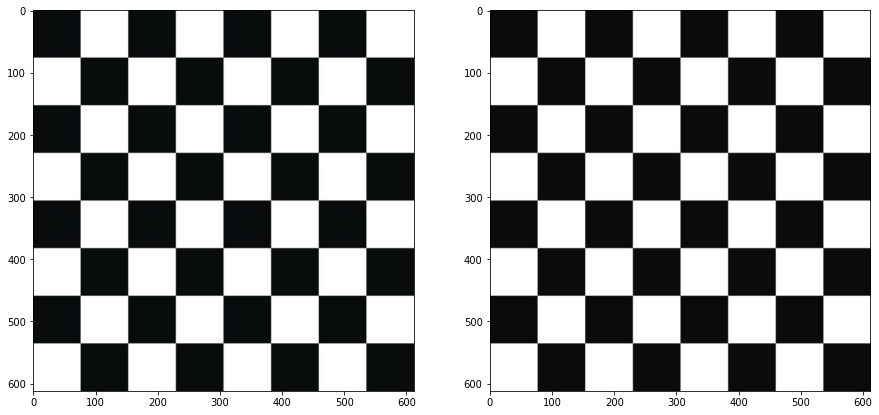

In [127]:
img = cv2.imread('data/chessboard.jpg')
img_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_color)
plt.subplot(1, 2, 2)
plt.imshow(img_gray, cmap="gray")

## 2. Spatial derivative calculation <a class="anchor" id="spatial" ></a>

In [128]:
def gradient_x(imggray):
    ##Sobel operator kernels.
    kernel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
    return sig.convolve2d(imggray, kernel_x, mode='same')

def gradient_y(imggray):
    kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    return sig.convolve2d(imggray, kernel_y, mode='same')

I_x = gradient_x(img_gray)
I_y = gradient_y(img_gray)

## 3. Structure tensor setup <a class="anchor" id="tensor" ></a>

In [129]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g


Ixx = convolve(I_x**2, gaussian_kernel(3, 1))
Ixy = convolve(I_y*I_x, gaussian_kernel(3, 1))
Iyy = convolve(I_y**2, gaussian_kernel(3, 1))

## 4. Harris response calculation <a class="anchor" id="response" ></a>

In [130]:
k = 0.05

# determinant
detA = Ixx * Iyy - Ixy ** 2

# trace
traceA = Ixx + Iyy
    
harris_response = detA - k * traceA ** 2

In [131]:
img_gray.shape

(612, 612)

In [132]:
window_size = 3
offset = window_size//2
width, height = img_gray.shape

for y in range(offset, height-offset):
    for x in range(offset, width-offset):
        Sxx = np.sum(Ixx[y-offset:y+1+offset, x-offset:x+1+offset])
        Syy = np.sum(Iyy[y-offset:y+1+offset, x-offset:x+1+offset])
        Sxy = np.sum(Ixy[y-offset:y+1+offset, x-offset:x+1+offset])

In [133]:
#Find determinant and trace, use to get corner response
det = (Sxx * Syy) - (Sxy**2)
trace = Sxx + Syy
r = det - k*(trace**2)

## 5. Find edges and corners using R <a class="anchor" id="find" ></a>

In [134]:
img_copy_for_corners = np.copy(img)
img_copy_for_edges = np.copy(img)

for rowindex, response in enumerate(harris_response):
    for colindex, r in enumerate(response):
        if r > 0:
            # this is a corner
            img_copy_for_corners[rowindex, colindex] = [255,0,0]
        elif r < 0:
            # this is an edge
            img_copy_for_edges[rowindex, colindex] = [0,255,0]

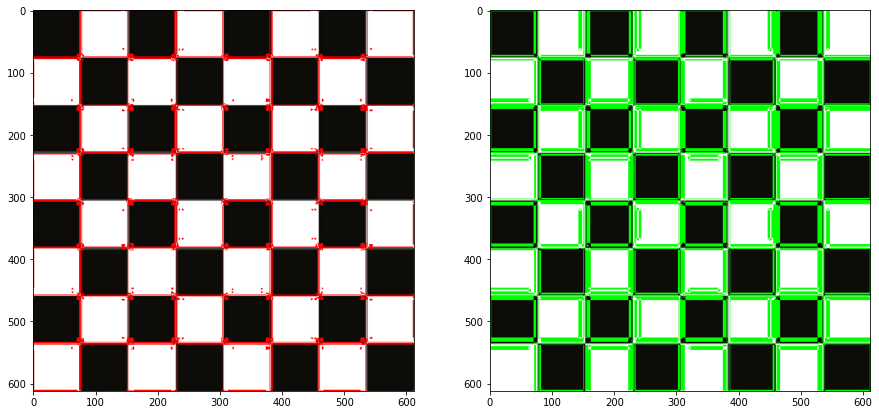

In [135]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_copy_for_corners, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(img_copy_for_edges, cmap="gray")

## Applications and Analysis <a class="anchor" id="applications" ></a>

For this exercise we are going to take three sets of photos, a very simple pokemon, one of a bust with different lighting and finally a third one of a bunny plush also with different light and slightly different angle. Using these two sets of images we will present how the Harris Corner Detection algorithm performs.

Let's first see the images of the bust with different lighting scenarios, original image from [1].

Image of a pokemon


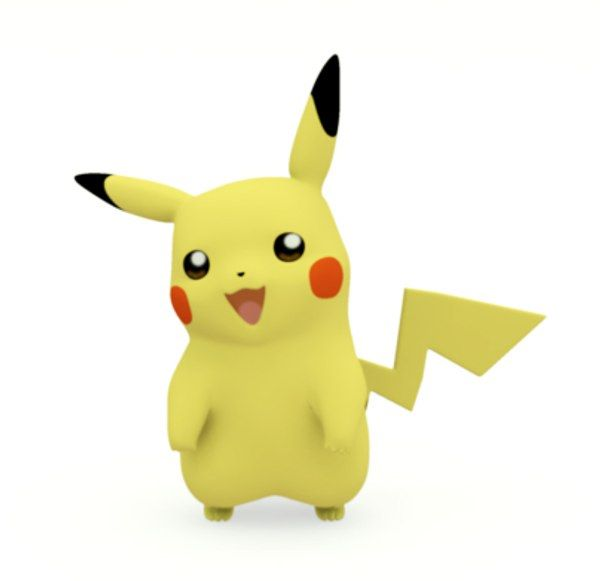

In [189]:
print("Image of a pokemon")
Image.open('./data/pikachu.jpg')

Images of bust under diffrent lighting 


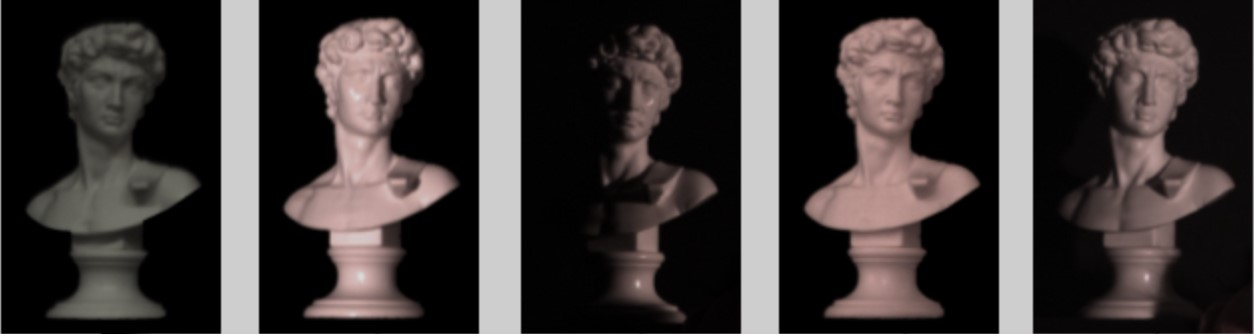

In [177]:
print("Images of bust under diffrent lighting ")
Image.open('./data/invariant_images.jpg')

We will implement a simple script to split the images into 4 tiles to then use it for the Harris-Corner algorithm.

In [166]:
from PIL import Image

# Open the image
img = Image.open('./data/invariant_images.jpg')

# Define the tile size
tile_width = img.width // 5
tile_height = img.height

# Loop through the tiles
for j in range(5):
    # Calculate the coordinates of the tile
    correction_left = [10, 10, 20, 30, 32]
    correction_right = [30, 20, 10, 5, 0]
    left = j * tile_width + correction_left[j]
    upper = 0
    right = (j + 1) * tile_width - correction_right[j]
    lower = tile_height

    # Crop and resize the tile
    tile = img.crop((left, upper, right, lower))
    tile.resize((200,200))

    tile.save(f'./data/tile_{j}.jpg')
    print(f"tile image saved in /data/tile_{j}.jpg")

    # Show the tile in the corresponding subplot
    

tile image saved in /data/tile_0.jpg
tile image saved in /data/tile_1.jpg
tile image saved in /data/tile_2.jpg
tile image saved in /data/tile_3.jpg
tile image saved in /data/tile_4.jpg


Now, let's take a look at the two images we will use of the bunny plush

Images of bunny plush


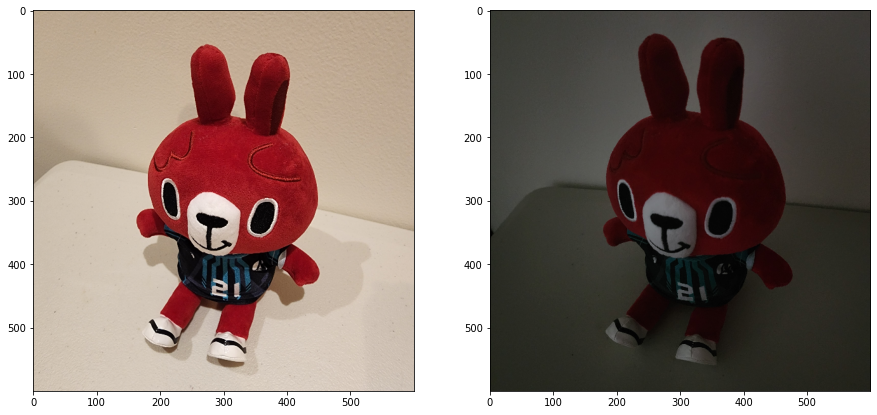

In [178]:
# First image
img_0 = cv2.imread('data/bunny_5.jpg')
img_0 = cv2.cvtColor(img_0, cv2.COLOR_BGR2RGB)
img_0 = cv2.resize(img_0, (600, 600))

# Second image
img_1 = cv2.imread('data/bunny_11.jpg')
img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
img_1 = cv2.resize(img_1, (600, 600))

# Canvas for output
print("Images of bunny plush")
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_0)
plt.subplot(1, 2, 2)
plt.imshow(img_1)
plt.show()

We will use the algorithm of the code below to analyze the pictures to find corners and edges.

In [179]:
# Required libraries
import cv2
import matplotlib.pyplot as plt
from scipy import signal as sig
import numpy as np
from scipy.ndimage.filters import convolve

# Main funciton
def harris_corner(imgpath, k, resize=False):
    """
    This function takes the path of an image, a parameter k for the Harris Corner algorithm and a resize property (in case image requires a resize to 600x600).
    It returns the image in a 4-tile where we can see the original image, that image in gray and the corners in red and edges in green.
    """

    # Open the image
    img = cv2.imread(imgpath)
    
    # If we require to resize
    if resize:
        img = cv2.resize(img, (600, 600))
    
    
    # To show the original image (cv2 is BGR for some reason...)
    orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Change the image to gray scale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Function to take the gradient of x Ix = df/dx
    def gradient_x(img):
        kernel_x = np.array([
            [-1, 0, 1],
            [-2, 0, 2],
            [-1, 0, 1]
        ])
        return sig.convolve2d(img, kernel_x, mode='same')

    # Function to take the gradient of y Iy = df/dy
    def gradient_y(img):
        kernel_y = np.array([
            [1,   2,  1],
            [0,   0,  0],
            [-1, -2, -1]
        ])
        return sig.convolve2d(img, kernel_y, mode='same')
        
    # Gaussian kernel to smooth the image        
    def gaussian_kernel(size, sigma=1):
        size = int(size) // 2
        x, y = np.mgrid[-size:size+1, -size:size+1]
        normal = 1 / (2.0 * np.pi * sigma**2)
        g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
        return g

    # We take the derivatives and product of those derivatives
    I_x = gradient_x(img_gray)
    I_y = gradient_y(img_gray)

    Ixx = convolve(I_x**2, gaussian_kernel(3, 1))
    Ixy = convolve(I_y*I_x, gaussian_kernel(3, 1))
    Iyy = convolve(I_y**2, gaussian_kernel(3, 1))

    # We then create the determinant measure
    detA = Ixx * Iyy - Ixy ** 2

    # We then creat the trace measure
    traceA = Ixx + Iyy
    
    # This creates our Harris Response for an isoquant K
    harris_response = detA - k * traceA ** 2

    # We want an image for corners and one for edges
    img_copy_for_corners = np.copy(orig_img)
    img_copy_for_edges = np.copy(orig_img)

    # Using the harris response we can color the edges and corners in different colors
    for rowindex, response in enumerate(harris_response):
        for colindex, r in enumerate(response):
            if r > 0:
                # this is a corner
                img_copy_for_corners[rowindex, colindex] = [255,0,0]
            elif r < 0:
                # this is an edge
                img_copy_for_edges[rowindex, colindex] = [0,255,0]


    # Canvas for output
    plt.figure(figsize=(15, 8))

    # Original Image
    a = plt.subplot(2, 2, 1)
    a.set_title('Original')
    plt.imshow(orig_img)

    # Image in gray scale
    b = plt.subplot(2, 2, 2)
    b.set_title('Gray image')
    plt.imshow(img_gray, cmap='gray')

    # Corners
    c = plt.subplot(2, 2, 3)
    c.set_title('Corners')
    plt.imshow(img_copy_for_corners, cmap='gray')
    
    # Edges
    d = plt.subplot(2, 2, 4)
    d.set_title('Edges')
    plt.imshow(img_copy_for_edges, cmap='gray')

    # Show all plots
    plt.show()

### Example one

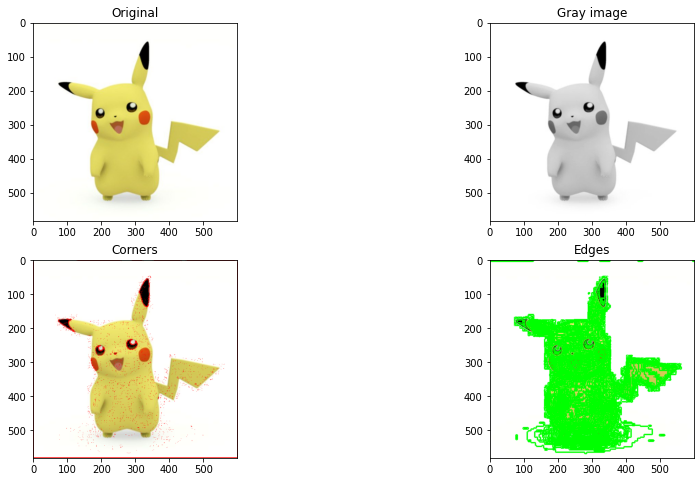

In [209]:
harris_corner('data/pikachu.jpg', 0.24)

In this example we can easily see how features like the ears, the eyes, the tail are being recognized by the algorithm and although there is some noise also in the body, it give us a general good idea of where the corners are

### Example two

For the example one we will take 3 shots of the bust image

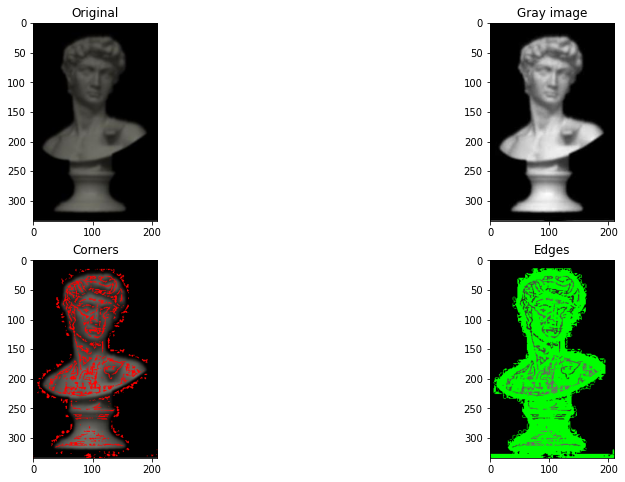

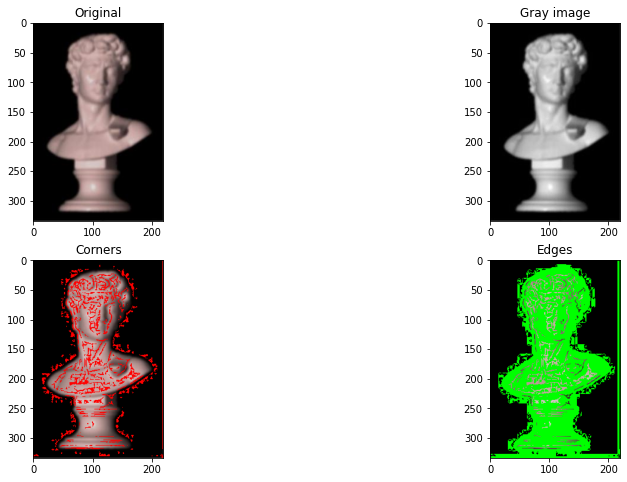

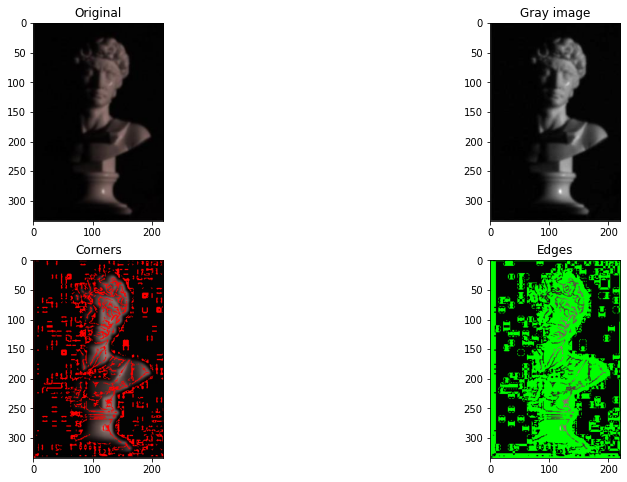

In [182]:
harris_corner('data/tile_0.jpg', 0.1)
harris_corner('data/tile_1.jpg', 0.1)
harris_corner('data/tile_2.jpg', 0.1)


Between the first and second image we notice slight differences, lighting here although distinct, has a negligible effect in the detection algorithm. When we look at the third picture, we start to see something different as the corners are detecting more noise; the general image is there but the effect is different; this suggest to us that the algorithm of Harris is somehow resistant to different lights, but it might be indeed affected.

It is important to recognize that the images analyzed here have the same angle and they tell little about how the algorithm responds to those changes, hence we will create a second analysis with a second set of pictures.

### Example three

We will now work with the image of the bunny plush

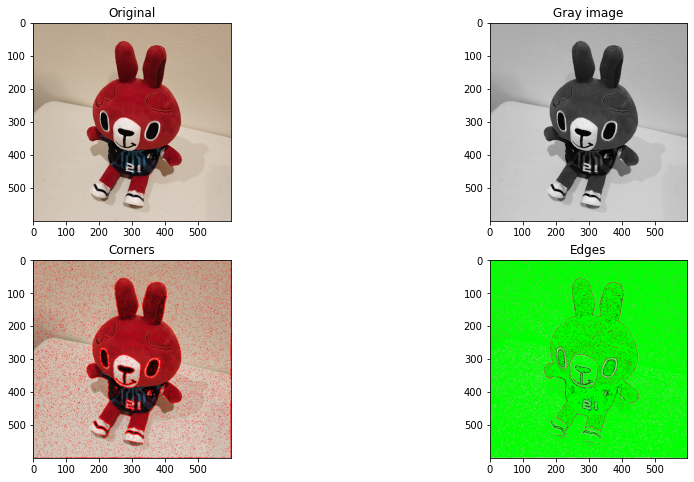

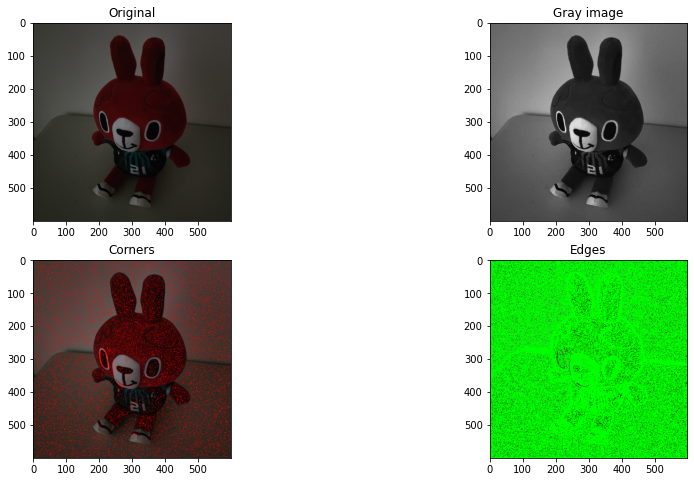

In [187]:
harris_corner('data/bunny_5.jpg', 0.24, True)
harris_corner('data/bunny_11.jpg', 0.24, True)

On this exercise we have the pictures of a bunny in a texturized background, this is, the walls and floor have an architecture feature that creates little bumps that the algorithm is detecting as corners; this is telling us a lot about the capacities of the algorithm. We will see next that by increasing by 0.1 from 0.24 to 0.25 our parameter K some of those features will stop being recognized as corners.

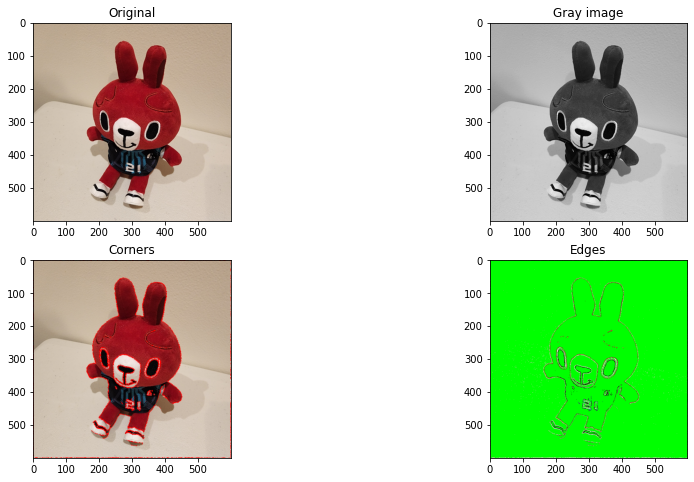

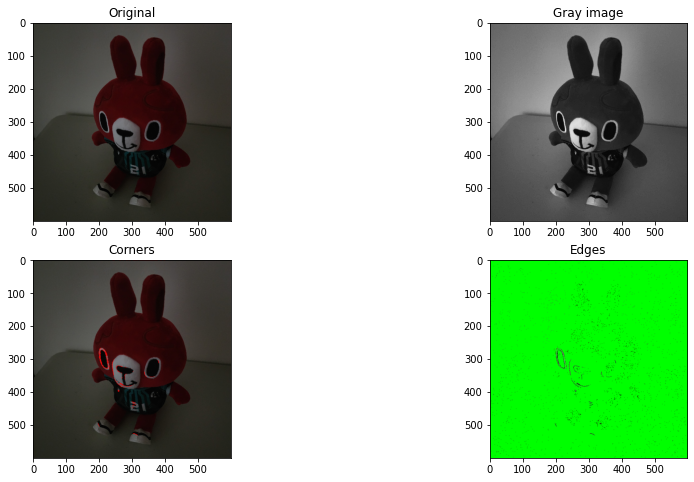

In [188]:
harris_corner('data/bunny_5.jpg', 0.25, True)
harris_corner('data/bunny_11.jpg', 0.25, True)

On this exercise we have the pictures of a bunny in a texturized background, this is, the walls and floor have an architecture feature that creates little bumps that the algorithm is detecting as corners; this is telling us a lot about the capacities of the algorithm. We will see next that by increasing by 0.1 from 0.24 to 0.25 our parameter K some of those features will stop being recognized as corners.

### Conclusions

Corners are an important part in computer vision, while edges appear an obvious choice they alone might lead to misinterpretations; corners, on the other hand, tend to have a better ability to capture characteristics of an image. In the exercise we used the Harris Corner Algorithm that uses the derivatives of X and Y to capture rapid movement in both directions to interpret a corner, we saw that it has resilience to illumination also to angles but, unfortunately, we also saw that it is by no means a silver bullet as noise can also be interpreted as corners.

We can say that the algorithm is good but there might be better methods nowadays we can use to find these corners and characteristics of images.

## References <a class="anchor" id="references" ></a>

[1] S. G. Narasimhan, V. Ramesh and S. K. Nayar (2003). A Class of Photometric Invariants: Separating Material from Shape and Illumination In Proc. International Conference on Computer Vision (ICCV)

[2] Gonzalez, R. C., & Woods, R. E. (2008). Digital Image Processing (3rd ed.). Pearson Education.
